# Set Up

## Colab Installation

Run the following code block if you are using this Jupyter notebook in Google Colab. Otherwise skip to importing the packages.

In [2]:
# Run these statements if you are using Google Colab. Otherwise skip this step.
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024

  Cloning https://github.com/QMCSoftware/QMCSoftware.git (to revision SURE2024) to c:\users\waine\appdata\local\temp\pip-req-build-n4_vfvra
  Resolved https://github.com/QMCSoftware/QMCSoftware.git to commit d19070ff3ee86f69f57218b65808e72ba6741d82
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for qmcpy: filename=qmcpy-1.4.5-cp39-cp39-win_amd64.whl size=7695007 sha256=75d1045a48fad4d790fc2287e686b47b172df533ef825c27fbaa9090edf99a1f
  Stored in directory: C:\Users\waine\AppData\Local\Temp\pip-ephem-wheel-cache-x654y6qu\wheels\ae\92\8c\9c3620765e56b81faafbec8c64f5d2d942604061db0c3369a2
Successfully built qmcpy


  Running command git clone --filter=blob:none --quiet https://github.com/QMCSoftware/QMCSoftware.git 'C:\Users\waine\AppData\Local\Temp\pip-req-build-n4_vfvra'
  Running command git checkout -b SURE2024 --track origin/SURE2024
  branch 'SURE2024' set up to track 'origin/SURE2024'.
  Switched to a new branch 'SURE2024'


## Importing Packages

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
# figpath = '' #this path sends the figures to the directory that you want
# savefigs = True  #save the figures on your disk if True
# imgfrmt = 'pdf' #kind of format to save figures as

# Definitions of Python Functions

The following functions are things that will be repeatedly used in the notebook so that there isn't duplicate code all over the place.

## Graphing Functions

The following functions are to help with graphing.

In [2]:
def make_grid(d=3, nper=2):
    """this function creates a nper^d x d matrix of grid points"""
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  # array of coordinate values
    xgrid = xpts  # initial grid
    n = nper  # initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  # store the old grid
        xgrid = np.vstack((xgrid0, xpts[0] * np.ones((1, n))))  # stack the next coordinate
        for jj in range(1, nper):
            xgrid = np.hstack((xgrid, np.vstack((xgrid0, xpts[jj] * np.ones((1, n))))))
        n = n * nper  # update the length of the grid
    return xgrid.T  # take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot=[0, 1], savefig=True, figpath=''):
    """Plots a dot grid."""
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot, [d, d]), # ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot, [1, 1]), # ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False)
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]), fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]), fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath + f"{n:.0f}gridpts_d{d:.0f}." + imgfrmt, format=imgfrmt)


In [3]:
def graph_kernel(bandwidths, lin_spaces, kernel, ylim_lst=[-0.05, 1.2]):
  """Graphs a given kernel, with given bandwidths, lin_spaces
  bandwidths = a list of bandwidths
  lin_spaces = a list of 3 integers: start, finish, and number of points"""
  ypts = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  nband = len(bandwidths)
  fig, ax = plt.subplots(1, 3, figsize=(5*nband, 5))
  for ii in range(nband):
      ax[ii].plot(ypts,kernel(ypts/bandwidths[ii]) / bandwidths[ii])
      ax[ii].grid(False)
      ax[ii].set_ylim(ylim_lst)
      ax[ii].set_xlabel(r'$y$', fontsize=20)
      ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)
    #   if (ii == 0):
    #       ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidths[ii], fontsize=20)
    #   else:
    #       ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)

In [4]:
def generate_sobol_iid_graph(bandwidths, lin_spaces, kde, kernel, yiid, ysob, ylim_lst=[-0.05, 1.2]):
  """Generates a graph using IID and Sobol sample points.
  bandwidths = a list of bandwidths
  lin_spaces = a list of 3 integers: start, finish, and number of points
  kde = name of kde function
  kernel = name of kernel function
  yiid = set of iid points
  ysob = set of LD points generated with sobol sequence"""
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  for ii in range(nband):
      rhovaliid = kde(kernel, yiid, bandwidths[ii], yeval)
      rhovalsob = kde(kernel, ysob, bandwidths[ii], yeval)
      fig,ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

In [5]:
def generate_graphs(bandwidths, lin_spaces, kde, kernel, sample_points, ylim_lst=[-0.05, 1.2]):
  """
  Generate graphs involving a kde, kernel, and sample_points.
  sample_points is a list of IID, Sobol, Lattice, DNB2, and Halton points.
  """
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  rho_list = list()
  for ii in range(nband):
      rhovaliid = kde(kernel, sample_points[0], bandwidths[ii], yeval)
      rhovalsob = kde(kernel, sample_points[1], bandwidths[ii], yeval)
      rhovallattice = kde(kernel, sample_points[2], bandwidths[ii], yeval)
      rhovaldnetb2 = kde(kernel, sample_points[3], bandwidths[ii], yeval)
      rhovalhalton = kde(kernel, sample_points[4], bandwidths[ii], yeval)
      fig, ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.plot(yeval, rhovallattice, label = "Lattice")
      ax.plot(yeval, rhovaldnetb2, label = "Digital Net B2")
      ax.plot(yeval, rhovalhalton, label = "Halton")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

## Generate Functions

The following functions are used to generate different types of sample points.

In [6]:
def gen_iid_and_sobol(dimen = 3, n = 2**12):
  """Generate IID and Sobol sample points based on given sample size and dimensions."""
  coord_wts = 2.0 ** (-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  return (iidpts, sobpts)

def gen_iid_ld_pts(dimen = 3, n = 2**12):
  """
  Generate IID, Sobol, Lattic, DNB2, and Halton sample points,
  based on dimension and smaple size.
  """
  coord_wts = 2.0**(-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  latticepts = qp.Lattice(dimen).gen_samples(n)
  dnetb2pts = qp.DigitalNetB2(dimen).gen_samples(n)
  haltonpts = qp.Halton(dimen).gen_samples(n)
  return (iidpts, sobpts, latticepts, dnetb2pts, haltonpts)

## Generating Points

Generating sequences of IID and LD points, with dimensions 1 and 3.

In [7]:
# dim = 1, n = 2**12
iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**12)
# print("iid: ", iidpts1)
# print("sobol: ", sobpts1)
# print("lattice: ", latticepts1)
# print("digital net B2: ", dnetb2pts1)
# print("halton: ", haltonpts1)

In [8]:
# dim = 1, n = 2**10
few_iidpts1, few_sobpts1, few_latticepts1, few_dnetb2pts1, few_haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**10)
# print("iid: ", few_iidpts1)
# print("sobol: ", few_sobpts1)
# print("lattice: ", few_latticepts1)
# print("digital net B2: ", few_dnetb2pts1)
# print("halton: ", few_haltonpts1)

In [9]:
# dim = 1, n = 2**14
many_iidpts1, many_sobpts1, many_latticepts1, many_dnetb2pts1, many_haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**14)
# print("iid: ", many_iidpts1)
# print("sobol: ", many_sobpts1)
# print("lattice: ", many_latticepts1)
# print("digital net B2: ", many_dnetb2pts1)
# print("halton: ", many_haltonpts1)

In [10]:
# dim = 3, n = 2**12
iidpts3, sobpts3, latticepts3, dnetb2pts3, haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**12)
# print("iid: ", iidpts3)
# print("sobol: ", sobpts3)
# print("lattice: ", latticepts3)
# print("digital net B2: ", dnetb2pts3)
# print("halton: ", haltonpts3)

In [11]:
# dim = 3, n = 2**10
few_iidpts3, few_sobpts3, few_latticepts3, few_dnetb2pts3, few_haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**10)
# print("iid: ", few_iidpts3)
# print("sobol: ", few_sobpts3)
# print("lattice: ", few_latticepts3)
# print("digital net B2: ", few_dnetb2pts3)
# print("halton: ", few_haltonpts3)

In [12]:
# dim = 3, n = 2**14
many_iidpts3, many_sobpts3, many_latticepts3, many_dnetb2pts3, many_haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**14)
# print("iid: ", many_iidpts3)
# print("sobol: ", many_sobpts3)
# print("lattice: ", many_latticepts3)
# print("digital net B2: ", many_dnetb2pts3)
# print("halton: ", many_haltonpts3)

## Kernels and KDEs

The following are definitions of different kernels used in the notebook. Some may be defined later, but these are ones used throughout the notebook or commonly used/known.

The gaussian kernel defined below represents the following:

$$
\frac{e^{-y^2}}{\sqrt{\pi}}
$$

In [13]:
def kernel(y):
    return np.exp(-y * y) / np.sqrt(np.pi)

#### Generate some $y_i=f(x_i)$ points
$
f(\mathbf{x}) = 10 \exp(- w_1x_1 - \cdots - w_d x_d) \sin(w_1x_1 + \cdots +w_d x_d)
$

In [14]:
def testfun1(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    y = 10 * np.exp(-wtx.sum(1)) * np.sin(np.pi * wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

In [15]:
yiid1 = testfun1(iidpts1)
ysob1 = testfun1(sobpts1)

yiid3 = testfun1(iidpts3)
ysob3 = testfun1(sobpts3)

In [16]:
many_yiid1 = testfun1(many_iidpts1)
many_ysob1 = testfun1(many_sobpts1)

many_yiid3 = testfun1(many_iidpts3)
many_ysob3 = testfun1(many_sobpts3)

In [17]:
few_yiid1 = testfun1(few_iidpts1)
few_ysob1 = testfun1(few_sobpts1)

few_yiid3 = testfun1(few_iidpts3)
few_ysob3 = testfun1(few_sobpts3)

The following *Kernel Density Estimator* (KDE)

$$
\varrho() = \frac{k\left(\frac{y - Y}{h}\right)}{h}
$$

*(Still needs work.)*

In [18]:
def kde(kernel, ypts, bandwidth, yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval) #values of density estimator
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts) / bandwidth)) / bandwidth
    return rhoval

In [19]:
def kde_pt(kernel, ypts, bandwidth, yeval):
    # neval = len(yeval)
    # rhoval = np.zeros_like(yeval) #values of density estimator
    # for ii in range(len(yeval)):
    #     rhoval[ii] = np.mean(kernel((yeval[ii]-ypts) / bandwidth)) / bandwidth
    return np.mean(kernel((yeval-ypts) / bandwidth)) / bandwidth

# Kernel Density Estimator for Uniform Distribution

In [20]:
def testfun_unif(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    # y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    y = x[:,0] # if x is uniform, then y is uniform
    return y

In [21]:
def testfun_unif_pt(x, coord_wts = 1): # function f(x) defines the random variable
    # wtx = np.multiply(x, coord_wts)
    # y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    # y = x[:,0] # if x is uniform, then y is uniform?
    return x

In [22]:
yiid_unif1 = testfun_unif(iidpts1)
ysob_unif1 = testfun_unif(sobpts1)

yiid_unif3 = testfun_unif(iidpts3)
ysob_unif3 = testfun_unif(sobpts3)

In [23]:
many_yiid_unif1 = testfun_unif(many_iidpts1)
many_ysob_unif1 = testfun_unif(many_sobpts1)

many_yiid_unif3 = testfun_unif(many_iidpts3)
many_ysob_unif3 = testfun_unif(many_sobpts3)

In [24]:
few_yiid_unif1 = testfun_unif(few_iidpts1)
few_ysob_unif1 = testfun_unif(few_sobpts1)

few_yiid_unif3 = testfun_unif(few_iidpts3)
few_ysob_unif3 = testfun_unif(few_sobpts3)

# Testing different LD sequences: Sobol, Lattice, Digital Net B2, and Halton

In [25]:
# iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts()
points1 = gen_iid_ld_pts(dimen = 1, n = 2**12) # dim = 1
points3 = gen_iid_ld_pts(dimen = 3, n = 2**12) # dim = 3

In [26]:
# using original function f(x)

lst_points1 = list()
lst_points3 = list()

for pts in points1:
  lst_points1.append(testfun1(pts))

for pts in points3:
  lst_points3.append(testfun1(pts))

# Testing Different Kernels

The following Python function definition is the expression:

$$
y=\begin{cases}
            \frac{\pi}{4}\cos\left(\frac{\pi}{2} y\right), & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [27]:
# cosine--has best performance according to paper?
def kernel_cos(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(math.pi/4)*np.cos((math.pi/2)*y)

The following Python function defines the kernel:

$$
y=\begin{cases}
            1 - |y|, & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [28]:
# triangular kernel
def kernel_tri(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(1 - np.absolute(y))

The following Python function defines the kernel:

$$
y=\begin{cases}
            \frac{1}{\pi} (1-\frac{y^2}{2}) e^-(\frac{y^2}{2}), & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [29]:
# laplacian of Gaussian--performed poorly according to paper
def kernel_laog(y):
    return np.heaviside(1-np.absolute(y), 1/2)*((1/math.pi)*(1-(y**2)/2)*np.exp(-(y**2)/2))

## Hermite Kernel

The following comes from Dr. Hickernell's KDE experiment notebook.


In [30]:
# Original hermite kernel function from Dr. Hickernell
y = sy.symbols('y', real = True)
h = sy.symbols('h', positive = True)
def sy_hermite_kernel(y = sy.symbols('y', real = True), band_width = sy.symbols('h', positive = True), r = 1, only_coef = False):
    '''
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    
#    import sympy as sy
    wt = sy.exp(-y*y) #normalizing weight for Hermite functions
    k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
    intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
    for ii in range(r):
        k[ii] = sy.hermite(2*ii,y)*wt #form the bases
        for jj in range(r):
            intk[jj,ii] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals against even degree monomials
            # to hardcode the above line:
            # r = 0: intk[jj, ii] = (np.exp(-y**2))/((math.pi)**0.5)
            # r = 1: intk[jj, ii] = ((3-2*y**2)*np.exp(-y**2))/(2*(math.pi)**0.5)
            # r = 2: intk[jj, ii] = ((4*y**4 - 20*y**2 +15)*np.exp(-y**2))/(8*(math.pi)**0.5)
    tot_int = sy.Matrix.vstack(sy.ones(1,1),sy.zeros(r-1,1)) #the kernel should integrate to one, 
        #and the kernel integrated against y, y^2, ..., y^r should be zero
#    print(tot_int)
    coef = sy.Matrix(list(sy.linsolve((intk,tot_int)))) #solve the system of equations for the coefficients of the bases
    if only_coef:
        return coef
    print(coef)
#    ktilde = coef.dot(k)
#    integk = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integk =',integk)
    ktilde = coef.dot(k.subs(y,y/band_width)/band_width) #form the isotropic kernel and insert the bandwidth dependency
#    integ = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integ =',integ)
#    print(band_width)
#    print(ktilde)
    return coef.dot(k.subs(y,y/band_width)/band_width)

In [31]:
# testing original hermite kernel function

test_kernel_sy = sy_hermite_kernel(r=1) # r = number terms in kernel
print(type(test_kernel_sy))
print('kernel =',test_kernel_sy)
integ = sy.integrate(test_kernel_sy,(y,-sy.oo,sy.oo))
print('integ =',integ) # should be 1
test_kernel_sy = sy_hermite_kernel(r=1,only_coef = True)
print(test_kernel_sy)
test_kernel_sy = sy_hermite_kernel(r=2,only_coef = True)
print(test_kernel_sy)
test_kernel_sy = sy_hermite_kernel(r=3,only_coef = True)
print(test_kernel_sy)

Matrix([[1/sqrt(pi)]])
<class 'sympy.core.mul.Mul'>
kernel = exp(-y**2/h**2)/(sqrt(pi)*h)
integ = 1
Matrix([[1/sqrt(pi)]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])


In [32]:
# hardcoding hermite kernel coefficients

def hardcode_hermite_kernel(r):
    '''
    returns hermite coefficients for r = 0, 1, or 2
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    if r==0:
        return sy.Matrix([[1/(math.pi)**0.5]])
    elif r==1:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5)]])
    elif r==2:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5), 1/(32*(math.pi)**0.5)]])
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")
    
# Coefficients: 
# r = 0 (corresponds to r = 1 from original function): Matrix([[1/sqrt(pi)]])
# r = 1 (corresponds to r = 2 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
# r = 2 (correpsonds to r = 3 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])

In [33]:
# hardcoding hermite kernel coefficients without sympy

def hardcode_hermite_kernel_simple(r):
    '''
    returns hermite coefficients for r = 0, 1, or 2
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    if r==0:
        return np.matrix([1/(math.pi)**0.5])
    elif r==1:
        return np.matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5)]])
    elif r==2:
        return np.matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5), 1/(32*(math.pi)**0.5)]])
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")
    
# Coefficients: 
# r = 0 (corresponds to r = 1 from original function): Matrix([[1/sqrt(pi)]])
# r = 1 (corresponds to r = 2 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
# r = 2 (correpsonds to r = 3 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])

In [34]:
# original function: define hermite kernel for r = 1 (corresopnds to r = 0 in the hardcoded case)
def hermite_kernel(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [35]:
# hardcoded: define hermite kernel for r = 0 (corresponds to r = 1 in the original case)
def hardcode_hermite_kernel_weight(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [36]:
# hardcoded without scipy: define hermite kernel for r = 0 (corresponds to r = 1 in the original case)
def simple_hardcode_hermite_kernel_weight(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    hermite_polys = [sp.poly1d([1.]), sp.poly1d([4.,  0., -2.]), sp.poly1d([ 1.6000000e+01,  0.0000000e+00, -4.8000000e+01, -8.8817842e-16,
        1.2000000e+01])]
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.poly1d([1.])(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += hermite_polys[r](y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [37]:
# original: define hermite kernel for r = 2 (corresopnds to r = 1 in the hardcoded case)
def hermite_kernel_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0) # why use the 0th polynomial?
    # print(poly)
    # for i in range(len(coef[0])):
    #     print(coef[0][i])
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [38]:
# hardcoded: define hermite kernel for r = 1 (corresponds to r = 2 in the original case)
def hardcode_hermite_kernel_weight_1(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [39]:
# hardcoded without scipy: define hermite kernel for r = 1 (corresponds to r = 2 in the original case)
def simple_hardcode_hermite_kernel_weight_1(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    hermite_polys = [sp.poly1d([1.]), sp.poly1d([4.,  0., -2.]), sp.poly1d([ 1.6000000e+01,  0.0000000e+00, -4.8000000e+01, -8.8817842e-16,
        1.2000000e+01])]
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.poly1d([1.])(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += hermite_polys[r](y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [40]:
# hardcoded: define hermite kernel for r = 2 (corresponds to r = 3 in the original case)
def hardcode_hermite_kernel_weight_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [41]:
# hardcoded: define hermite kernel for r = 2 (corresponds to r = 3 in the original case)
def simple_hardcode_hermite_kernel_weight_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    hermite_polys = [sp.poly1d([1.]), sp.poly1d([4.,  0., -2.]), sp.poly1d([ 1.6000000e+01,  0.0000000e+00, -4.8000000e+01, -8.8817842e-16,
        1.2000000e+01])]
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.poly1d([1.])(y)*coef[0][0]  #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += hermite_polys[r](y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [42]:
# using simplified np.matrix for coefficients, instead of sympy.matrix
def hardcode_hermite_kernel_weight_v2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel_simple(r = r)))
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y) * coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0, r):
        k += sp.special.hermite(2*ii)(y) * coef[0][ii] #add the additional terms
    k *= np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

## Testing Different Functions f(x)--using Gaussian kernel in all cases.

### Exponential Distribution: 

If X has a standard uniform distribution, i.e., $X \sim U(0, 1)$, then the random variable $Y = -\lambda^{-1} ln(X)$ has an exponential distribution with rate parameter $\lambda$.

In [43]:
# exponential, lambda = 1:
def testfun_exp(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    y = -np.log(wtx)
    return y

In [44]:
def testfun_exp_pt(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    y = -np.log(abs(wtx))
    return y

In [45]:
yiid1_exp = testfun_exp(iidpts1)
ysob1_exp = testfun_exp(sobpts1)

yiid3_exp = testfun_exp(iidpts3)
ysob3_exp = testfun_exp(sobpts3)

### Laplace Distribution:

If X and Y have a standard uniform distribution, i.e., $X, Y \sim U(0, 1)$, then $\log{}{\frac{X}{Y}} \sim \text{Laplace}(0, 1)$. 

In [46]:
## laplace: mu = 0, b = 1
def testfun_laplace(x1,x2,coord_wts = 1): # function f(x) defines the random variable
    wtx1 = np.multiply(x1,coord_wts)
    wtx2 = np.multiply(x2,coord_wts)
    y = np.log10(wtx1/wtx2)
    return y

In [47]:
# making a second set of iid and sobol points

iidpts1_2, sobpts1_2 = gen_iid_and_sobol(dimen = 1, n = 2**12)
iidpts3_2, sobpts3_2 = gen_iid_and_sobol(dimen = 3, n = 2**12)

In [48]:
yiid_laplace = testfun_laplace(iidpts1, iidpts1_2) 
ysob_laplace = testfun_laplace(sobpts1, sobpts1_2)

yiid_laplace_3 = testfun_laplace(iidpts3, iidpts3_2) 
ysob_laplace_3 = testfun_laplace(sobpts3, sobpts3_2)

## Error Analysis:

In [49]:
# import scipy.integrate as integrate

In [50]:
# def true_func(true_func, x):
#     '''
#     returns the true value of a function given an input x
#     true_func = the function we are trying to estimate (e.g., f(x), exponential PDF, laplace PDF, etc.)
#     x = a float
#     '''
#     return true_func(x)

In [51]:
# def estimated_pts(kde_func, kernel_func, points, bw, x):
#     '''
#     returns the estimation of a function at a point x using the specified KDE
#     kde_func = the function that builds the KDE
#     kernel_func = function that defines the kernel
#     points = an array of randomly-generated iid or ld points
#     bw = bandwidth (a float)
#     x = a float
#     '''
#     return kde_func(kernel_func, points, bw, x)

In [52]:
# def squared_difference(true_func, estimate_func, x):
#     '''
#     returns the squared error between the true value and estimated value at a point x
#     true_func = actual function that we are trying to estimate (e.g., f(x), exponential PDF, laplace PDF, etc.)
#     estimate_func = function that returns estimation of the function at the point x
#     x = a float
#     '''
#     return (true_func(x) - estimate_func(x))**2

In [53]:
# def optimal_h(h_space, pts, kde, kernel, true_function):
#     '''
#     returns optimal bandwidth and lowest value of MISE
#     h_space: a set of bandwidths to be tested (e.g., np.linspace(0.001, 3, 100))
#     pts: set of randomly generated points (IID or LD)
#     kde: kde function
#     kernel: function that defines kernel
#     true_function: function that we are trying to estimate (e.g., uniform, exponential, etc.)
#     '''

#     h_optimal = 0
#     lowest_mise = np.inf

#     for h in h_space:
#         def estimated_pts(x):
#             return kde(kernel, pts, h, x)
#         def squared_difference_pts(x):
#             return (true_function(x) - estimated_pts(x))**2
#         mise, error = integrate.quad(squared_difference_pts, -4, 8)
#         if mise < lowest_mise:
#             lowest_mise = mise
#             h_optimal = h

#     return(lowest_mise, h_optimal)

### Normal distribution

In [54]:
from scipy.stats import norm 
import numpy as np

def rmse_normal(h, n, pts, kernel, kde):
    '''
    returns rmse for a KDE that estimates a uniformly distributed random variable
    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    '''

    sum_errors = 0

    normal = np.linspace(-4, 8, 500)    #1. update normal distribution 
    
    for i in range(len(normal)):
       normal[i]=norm.pdf(normal[i], loc=0, scale=1)
    
    rhoval = kde(kernel, pts, h, np.linspace(-4, 8, 500))

    for i in range(500):
        sum_errors += (normal[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [55]:
#2. transforming points 
import scipy.stats as stats 

# use scipy for normal dist.--inverse CDF
def testfun_normal(x, coord_wts = 1):  #takign one uniform rv and transofmring into a normal 
    wtx= np.multiply(x, coord_wts)
    normal_rv = stats.norm.pdf(wtx)
    return normal_rv

In [56]:
yiid1_normal=testfun_normal(iidpts1)
yiid3_normal=testfun_normal(iidpts3)

ysob1_normal=testfun_normal(sobpts1)
ysob3_normal=testfun_normal(sobpts3)

In [57]:
print(rmse_normal(0.1, 2**12, ysob3_normal, kernel, kde))

0.16860338519373388


In [58]:
h_list = np.linspace(0.001, 1, 100)
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_normal(h_list[i], 2**12, ysob3_normal, kernel, kde))

In [59]:
print(rmse_list)

[0.19846798673465477, 0.2488615567364915, 0.23488976806799033, 0.22277552314706697, 0.2128862096856272, 0.20422583734732408, 0.19617714185825452, 0.18848475311145182, 0.18110074099959547, 0.1740512475410552, 0.16736810517512962, 0.1610674618037623, 0.15514865492628688, 0.14959884295319076, 0.14439791086571394, 0.13952218432284172, 0.1349468855005015, 0.1306476233258007, 0.1266012261138784, 0.12278615399459536, 0.11918265458977827, 0.11577276840716486, 0.11254025101608034, 0.10947045320862675, 0.10655018385539898, 0.1037675698342288, 0.10111192103134163, 0.09857360453001315, 0.0961439297773186, 0.09381504516277432, 0.09157984568149867, 0.08943189095626251, 0.08736533271246051, 0.08537485074764917, 0.08345559645734778, 0.08160314303732254, 0.07981344155907501, 0.07808278219761428, 0.07640775997188884, 0.07478524443476253, 0.07321235281935548, 0.07168642621129968, 0.07020500837201828, 0.06876582688691867, 0.067366776354966, 0.06600590337311665, 0.06468139310117942, 0.06339155722044809, 0.

In [60]:
min_index = rmse_list.index(min(rmse_list))
print("Minimum rmse = " 
      + str(rmse_list[min_index]) 
      + "\nand corresponding bandwidth is " 
      + str(h_list[min_index])
      + ".\nLog of bandwidth is "
      + str(np.log(h_list[min_index])))

Minimum rmse = 0.02339356291033701
and corresponding bandwidth is 1.0.
Log of bandwidth is 0.0


In [61]:
h_list_log = []
for i in range(len(h_list)):
    h_list_log.append(np.log(h_list[i]))

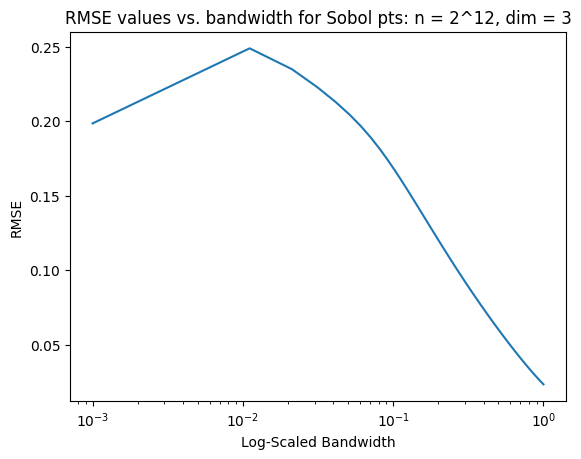

In [62]:
fix, ax = plt.subplots()
ax.plot(h_list, rmse_list)
ax.set_title("RMSE values vs. bandwidth for Sobol pts: n = 2^12, dim = 3")
ax.set_xlabel('Log-Scaled Bandwidth')
ax.set_ylabel('RMSE')
ax.set_xscale('log')

In [63]:
# normal, iid, dim = 1, but with a different h_list
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_normal(h_list[i], 2**14, yiid1_normal, kernel, kde))
rmse_list

[0.1011153666550269,
 0.11445871125039261,
 0.13193697007947416,
 0.125605710552229,
 0.11842017866375595,
 0.1075009179525831,
 0.08450360067815915,
 0.060135955362268394,
 0.036978509839871346,
 0.011704840157329319]

In [64]:
# Import pandas library
import pandas as pd

# Initialize data to Dicts of series. uniform, iid, dim = 1
d = {'2^10': pd.Series([0.38845585854958264, 0.4300380739483409, 0.5168673020999843, 0.5032518345210842, 0.47393103058479646, 
                        0.4277327808528639, 0.3366335105324015, 0.24018621542702634, 0.14783744404004173, 0.04681201442964332],
                        index=['0.001', '0.112', '0.223', '0.334', '0.445', '0.556', '0.667', '0.778', '0.889', '1']),
    '2^11': pd.Series([0.2746797717720522, 0.30408283825727384, 0.3654803742884948, 0.35585278483442895, 0.33511984554123864,
                       0.3024527498768395, 0.23803583807209416, 0.1698373016759833, 0.10453685919400026, 0.0331010928442033],
                      index=['0.001', '0.112', '0.223', '0.334', '0.445', '0.556', '0.667', '0.778', '0.889', '1']),
    '2^12': pd.Series([0.19422792927479132, 0.21501903697417046, 0.25843365104999216, 0.2516259172605421, 0.23696551529239823,
                       0.21386639042643196, 0.16831675526620074, 0.12009310771351317, 0.07391872202002087, 0.02340600721482166],
                      index=['0.001', '0.112', '0.223', '0.334', '0.445', '0.556', '0.667', '0.778', '0.889', '1']),
    '2^13': pd.Series([0.1373398858860261, 0.15204141912863692, 0.1827401871442474, 0.17792639241721447, 0.16755992277061932,
                       0.15122637493841976, 0.11901791903604708, 0.08491865083799165, 0.05226842959700013, 0.01655054642210165],
                      index=['0.001', '0.112', '0.223', '0.334', '0.445', '0.556', '0.667', '0.778', '0.889', '1']),
    '2^14': pd.Series([0.09711396463739566, 0.10750951848708523, 0.12921682552499608, 0.12581295863027106, 0.11848275764619912,
                       0.10693319521321598, 0.08415837763310037, 0.060046553856756585, 0.03695936101001043, 0.01170300360741083],
                      index=['0.001', '0.112', '0.223', '0.334', '0.445', '0.556', '0.667', '0.778', '0.889', '1'])
                      }

# creates Dataframe.
df = pd.DataFrame(d)

# print the data.
print(df)

           2^10      2^11      2^12      2^13      2^14
0.001  0.388456  0.274680  0.194228  0.137340  0.097114
0.112  0.430038  0.304083  0.215019  0.152041  0.107510
0.223  0.516867  0.365480  0.258434  0.182740  0.129217
0.334  0.503252  0.355853  0.251626  0.177926  0.125813
0.445  0.473931  0.335120  0.236966  0.167560  0.118483
0.556  0.427733  0.302453  0.213866  0.151226  0.106933
0.667  0.336634  0.238036  0.168317  0.119018  0.084158
0.778  0.240186  0.169837  0.120093  0.084919  0.060047
0.889  0.147837  0.104537  0.073919  0.052268  0.036959
1      0.046812  0.033101  0.023406  0.016551  0.011703


Text(103.84722222222221, 0.5, 'Bandwidth')

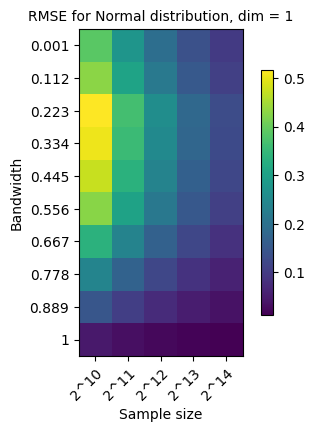

In [65]:
import numpy as np
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(df)
ax.set_title("RMSE for Normal distribution, dim = 1", size=10)
fig.tight_layout()

yaxis = df.index.values
xaxis = df.columns.values
# Add axis tick labels
ax.set_xticks(np.arange(len(xaxis)), 
              labels=xaxis)
ax.set_yticks(np.arange(len(yaxis)), 
              labels=yaxis)

cbar = ax.figure.colorbar(im, 
                          ax = ax,
                          shrink=0.75)

# Rotate the tick labels to be more legible
plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha = "right",
         rotation_mode = "anchor")

plt.xlabel("Sample size") 
plt.ylabel("Bandwidth") 

### Uniformly distributed random variable

In [133]:
import array as arr

In [134]:
xeval = arr.array('d', np.linspace(-4, 8, 500))

In [135]:
xeval

array('d', [-4.0, -3.975951903807615, -3.9519038076152304, -3.9278557114228456, -3.903807615230461, -3.879759519038076, -3.8557114228456912, -3.8316633266533064, -3.8076152304609217, -3.7835671342685373, -3.7595190380761525, -3.7354709418837677, -3.711422845691383, -3.687374749498998, -3.6633266533066133, -3.6392785571142285, -3.6152304609218437, -3.591182364729459, -3.567134268537074, -3.5430861723446894, -3.5190380761523046, -3.49498997995992, -3.470941883767535, -3.44689378757515, -3.4228456913827654, -3.3987975951903806, -3.3747494989979963, -3.350701402805611, -3.3266533066132267, -3.3026052104208414, -3.278557114228457, -3.2545090180360723, -3.2304609218436875, -3.2064128256513027, -3.182364729458918, -3.158316633266533, -3.1342685370741483, -3.1102204408817635, -3.0861723446893787, -3.062124248496994, -3.038076152304609, -3.0140280561122244, -2.9899799599198396, -2.965931863727455, -2.94188376753507, -2.9178356713426856, -2.8937875751503004, -2.869739478957916, -2.84569138276553

In [138]:
unif = xeval

In [139]:
unif

array('d', [-4.0, -3.975951903807615, -3.9519038076152304, -3.9278557114228456, -3.903807615230461, -3.879759519038076, -3.8557114228456912, -3.8316633266533064, -3.8076152304609217, -3.7835671342685373, -3.7595190380761525, -3.7354709418837677, -3.711422845691383, -3.687374749498998, -3.6633266533066133, -3.6392785571142285, -3.6152304609218437, -3.591182364729459, -3.567134268537074, -3.5430861723446894, -3.5190380761523046, -3.49498997995992, -3.470941883767535, -3.44689378757515, -3.4228456913827654, -3.3987975951903806, -3.3747494989979963, -3.350701402805611, -3.3266533066132267, -3.3026052104208414, -3.278557114228457, -3.2545090180360723, -3.2304609218436875, -3.2064128256513027, -3.182364729458918, -3.158316633266533, -3.1342685370741483, -3.1102204408817635, -3.0861723446893787, -3.062124248496994, -3.038076152304609, -3.0140280561122244, -2.9899799599198396, -2.965931863727455, -2.94188376753507, -2.9178356713426856, -2.8937875751503004, -2.869739478957916, -2.84569138276553

In [66]:
def rmse_unif(h, n, pts, kernel, kde):
    '''
    returns rmse for a KDE that estimates a uniformly distributed random variable
    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    '''

    sum_errors = 0

    xeval = np.linspace(-4, 8, 500)

    unif = np.linspace(-4, 8, 500)

    # array operations
    for i in range(len(unif)):
        if 0 < unif[i] < 1:
            unif[i] = 1
        else:
            unif[i] = 0
    
    rhoval = kde(kernel, pts, h, np.linspace(-4, 8, 500))

    for i in range(500):
        sum_errors += (unif[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [67]:
print(rmse_unif(0.1, 2**12, yiid_unif1, kernel, kde))

0.018599307127442163


In [68]:
h_list = np.linspace(0.001, 1, 100)
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_unif(h_list[i], 2**12, yiid_unif3, kernel, kde))

In [ ]:
rmse_list

In [70]:
min_index = rmse_list.index(min(rmse_list))
print("Minimum rmse = " 
      + str(rmse_list[min_index]) 
      + "\nand corresponding bandwidth is " 
      + str(h_list[min_index])
      + ".\nLog of bandwidth is "
      + str(np.log(h_list[min_index])))

Minimum rmse = 0.01023349996615954
and corresponding bandwidth is 0.021181818181818184.
Log of bandwidth is -3.854612098214807


In [71]:
h_list_log = []
for i in range(len(h_list)):
    h_list_log.append(np.log(h_list[i]))

In [ ]:
h_list_log

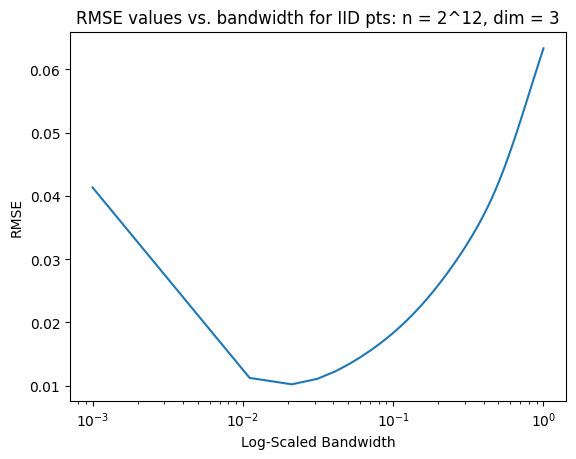

In [73]:
fix, ax = plt.subplots()
ax.plot(h_list, rmse_list)
ax.set_title("RMSE values vs. bandwidth for IID pts: n = 2^12, dim = 3")
ax.set_xlabel('Log-Scaled Bandwidth')
ax.set_ylabel('RMSE')
ax.set_xscale('log')

In [74]:
n_list = [2**10, 2**11, 2**12, 2**13, 2**14]
bandwidth = 0.001
rmse_list = []

for n in n_list:
    iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts(dimen = 1, n = n)
    # iidpts3, sobpts3, latticepts3, dnetb2pts3, haltonpts3 = gen_iid_ld_pts(dimen = 1, n = n)
    # yiid_unif1 = testfun_unif(iidpts1)
    # ysob_unif1 = testfun_unif(sobpts1)
    # yiid_unif3 = testfun_unif(iidpts3)
    ysob_unif3 = testfun_unif(sobpts3)
    rmse_list.append(rmse_unif(bandwidth, n, ysob_unif3, kernel, kde))

Text(0, 0.5, 'RMSE')

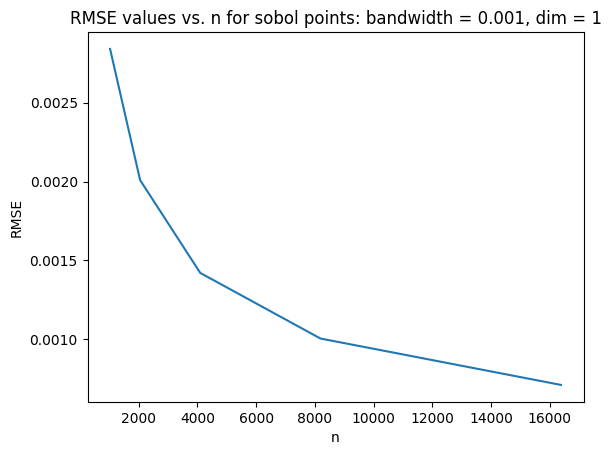

In [75]:
fix, ax = plt.subplots()
ax.plot(n_list, rmse_list)
ax.set_title("RMSE values vs. n for sobol points: bandwidth = 0.001, dim = 1")
ax.set_xlabel('n')
ax.set_ylabel('RMSE')

In [76]:
# uniform, iid, dim = 1
h_list = np.linspace(0.001, 1, 10)
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_unif(h_list[i], 2**14, yiid_unif1, kernel, kde))
rmse_list

[0.017955248056145522,
 0.009811812011317656,
 0.013690064916169493,
 0.016688339156484152,
 0.019460391367312823,
 0.02227149600992856,
 0.025010387095607642,
 0.027515253489715945,
 0.029716993036068857,
 0.03161693809173359]

In [77]:
h_list

array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ])

In [78]:
# Import pandas library
import pandas as pd

# Initialize data to Dicts of series. uniform, iid, dim = 1
d = {'2^10': pd.Series([0.05316609759686515, 0.038738075647372944, 0.05476870370890056, 0.06699400715121268, 0.07809524539969111,
                         0.0892879912909519, 0.10018693183690204, 0.11016336094539986, 0.1189406982110262, 0.1265204767883968],
                      index=['0.001', '0.112', '0.223', '0.334', '0.445', '0.556', '0.667', '0.778', '0.889', '1']),
    '2^11': pd.Series([0.037594108139969155, 0.027391955980374867, 0.0387273217893604, 0.04737191675548254, 0.055221677600549114,
                        0.06313614412035749, 0.07084285888814784, 0.0778972595627935, 0.08410377426407928, 0.08946348709603057],
                      index=['0.001', '0.112', '0.223', '0.334', '0.445', '0.556', '0.667', '0.778', '0.889', '1']),
    '2^12': pd.Series([0.026583048798432575, 0.019369037823686472, 0.02738435185445028, 0.03349700357560634, 0.039047622699845554,
                       0.04464399564547595, 0.05009346591845102, 0.05508168047269993, 0.0594703491055131, 0.0632602383941984],
                      index=['0.001', '0.112', '0.223', '0.334', '0.445', '0.556', '0.667', '0.778', '0.889', '1']),
    '2^13': pd.Series([0.018797054069984578, 0.013695977990187434, 0.0193636608946802, 0.02368595837774127, 0.027610838800274557,
                       0.031568072060178747, 0.03542142944407392, 0.03894862978139675, 0.04205188713203964, 0.04473174354801528],
                      index=['0.001', '0.112', '0.223', '0.334', '0.445', '0.556', '0.667', '0.778', '0.889', '1']),
    '2^14': pd.Series([0.013291524399216288, 0.009684518911843236, 0.01369217592722514, 0.01674850178780317, 0.019523811349922777,
                       0.022321997822737975, 0.02504673295922551, 0.027540840236349964, 0.02973517455275655, 0.0316301191970992],
                      index=['0.001', '0.112', '0.223', '0.334', '0.445', '0.556', '0.667', '0.778', '0.889', '1'])
                      }

# creates Dataframe.
df = pd.DataFrame(d)

# print the data.
print(df)

           2^10      2^11      2^12      2^13      2^14
0.001  0.053166  0.037594  0.026583  0.018797  0.013292
0.112  0.038738  0.027392  0.019369  0.013696  0.009685
0.223  0.054769  0.038727  0.027384  0.019364  0.013692
0.334  0.066994  0.047372  0.033497  0.023686  0.016749
0.445  0.078095  0.055222  0.039048  0.027611  0.019524
0.556  0.089288  0.063136  0.044644  0.031568  0.022322
0.667  0.100187  0.070843  0.050093  0.035421  0.025047
0.778  0.110163  0.077897  0.055082  0.038949  0.027541
0.889  0.118941  0.084104  0.059470  0.042052  0.029735
1      0.126520  0.089463  0.063260  0.044732  0.031630


Text(103.84722222222221, 0.5, 'Bandwidth')

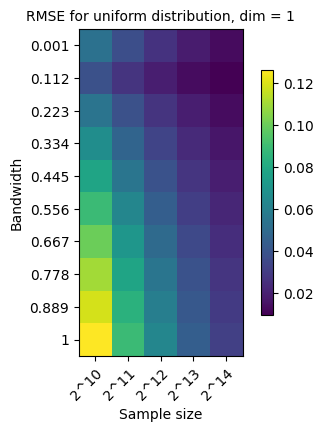

In [79]:
import numpy as np
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(df)
ax.set_title("RMSE for uniform distribution, dim = 1", size=10)
fig.tight_layout()

yaxis = df.index.values
xaxis = df.columns.values
# Add axis tick labels
ax.set_xticks(np.arange(len(xaxis)), 
              labels=xaxis)
ax.set_yticks(np.arange(len(yaxis)), 
              labels=yaxis)

cbar = ax.figure.colorbar(im, 
                          ax = ax,
                          shrink=0.75)

# Rotate the tick labels to be more legible
plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha = "right",
         rotation_mode = "anchor")

plt.xlabel("Sample size") 
plt.ylabel("Bandwidth") 

In [80]:
# uniform, iid, dim = 1, but with a different h_list
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_unif(h_list[i], 2**14, yiid_unif1, kernel, kde))
rmse_list

[0.017955248056145522,
 0.011612118683159237,
 0.007726052975990432,
 0.005165280478946413,
 0.005012827304436772,
 0.006115094309198768,
 0.009299653563721082,
 0.01298679603977163,
 0.018335720477549656,
 0.03161693809173359]

In [81]:
h_list

[0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]

In [82]:
# Import pandas library
import pandas as pd

# Initialize data to Dicts of series. uniform, iid, dim = 1
d = {'2^10': pd.Series([0.07178823191220095, 0.05312570833370878, 0.03693427380532819, 0.023720330013516668, 0.02186698160900411,
                        0.025641932945977594, 0.038243273708295125, 0.0521736334495133, 0.07312567258146638, 0.12641420688288418],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^11': pd.Series([0.0507619455945098, 0.037565548618104155, 0.026116475465948235, 0.016772806204540424, 0.01546229097980833,
                        0.018131584668831503, 0.027042078173908687, 0.036892330011292135, 0.05170765896118206, 0.08938834292520653],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^12': pd.Series([0.035894115956100474, 0.02656285416685439, 0.018467136902664095, 0.011860165006758334, 0.010933490804502056,
                       0.012820966472988797, 0.019121636854147563, 0.02608681672475665, 0.03656283629073319, 0.06320710344144209],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^13': pd.Series([0.0253809727972549, 0.018782774309052078, 0.013058237732974117, 0.008386403102270212, 0.007731145489904165,
                       0.009065792334415752, 0.013521039086954343, 0.018446165005646067, 0.02585382948059103, 0.044694171462603266],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^14': pd.Series([0.017947057978050237, 0.013281427083427194, 0.009233568451332047, 0.005930082503379167, 0.005466745402251028,
                       0.0064104832364943985, 0.009560818427073781, 0.013043408362378325, 0.018281418145366594, 0.031603551720721046],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1'])
                      }

# creates Dataframe.
df = pd.DataFrame(d)

# print the data.
print(df)

           2^10      2^11      2^12      2^13      2^14
0.001  0.071788  0.050762  0.035894  0.025381  0.017947
0.002  0.053126  0.037566  0.026563  0.018783  0.013281
0.004  0.036934  0.026116  0.018467  0.013058  0.009234
0.01   0.023720  0.016773  0.011860  0.008386  0.005930
0.02   0.021867  0.015462  0.010933  0.007731  0.005467
0.04   0.025642  0.018132  0.012821  0.009066  0.006410
0.1    0.038243  0.027042  0.019122  0.013521  0.009561
0.2    0.052174  0.036892  0.026087  0.018446  0.013043
0.4    0.073126  0.051708  0.036563  0.025854  0.018281
1      0.126414  0.089388  0.063207  0.044694  0.031604


Text(103.84722222222221, 0.5, 'Bandwidth')

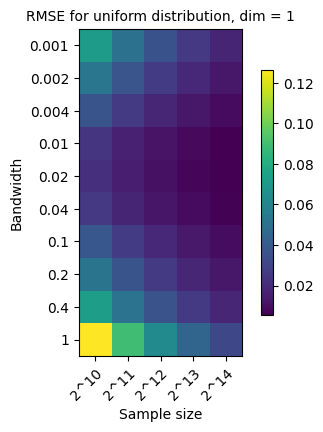

In [83]:
import numpy as np
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(df)
ax.set_title("RMSE for uniform distribution, dim = 1", size=10)
fig.tight_layout()

yaxis = df.index.values
xaxis = df.columns.values
# Add axis tick labels
ax.set_xticks(np.arange(len(xaxis)), 
              labels=xaxis)
ax.set_yticks(np.arange(len(yaxis)), 
              labels=yaxis)

cbar = ax.figure.colorbar(im, 
                          ax = ax,
                          shrink=0.75)

# Rotate the tick labels to be more legible
plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha = "right",
         rotation_mode = "anchor")

plt.xlabel("Sample size") 
plt.ylabel("Bandwidth") 

# does optimal bandwidth change with n?
# plot rmse vs. xeval

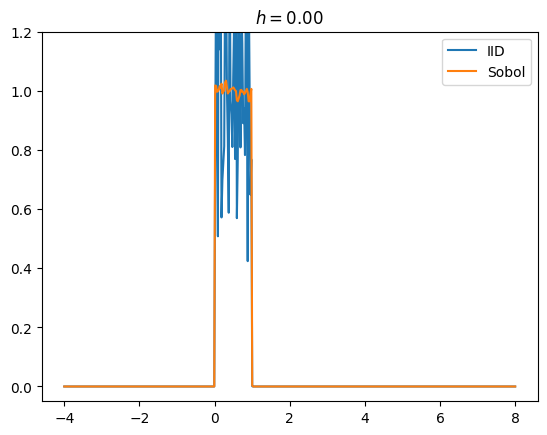

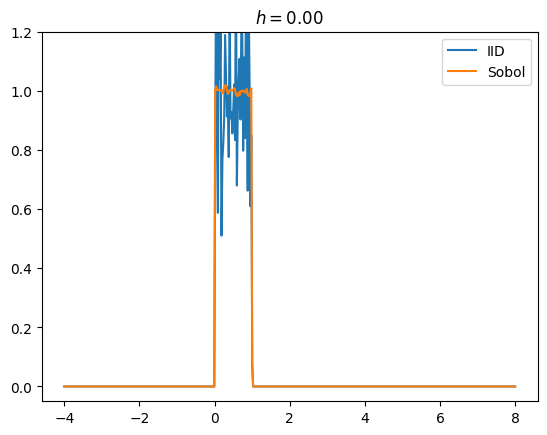

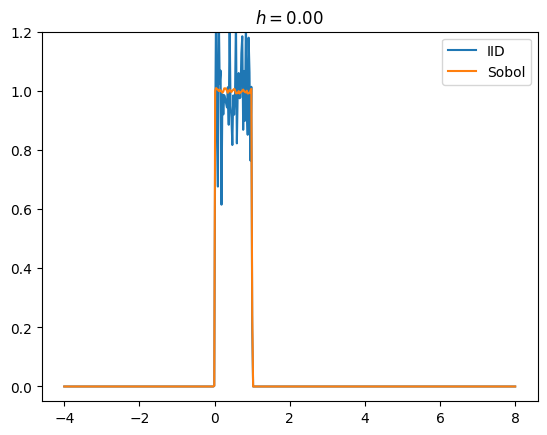

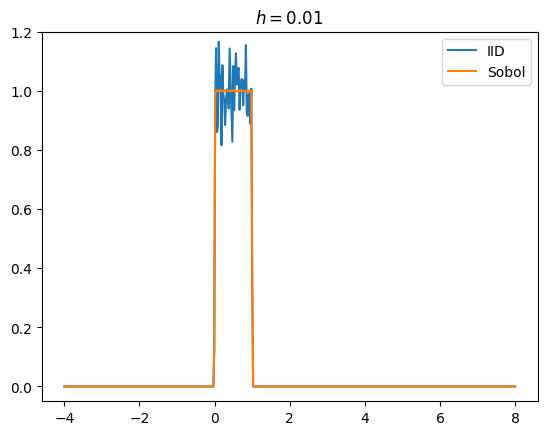

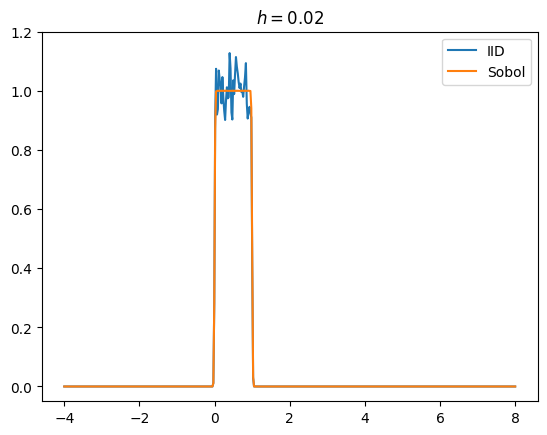

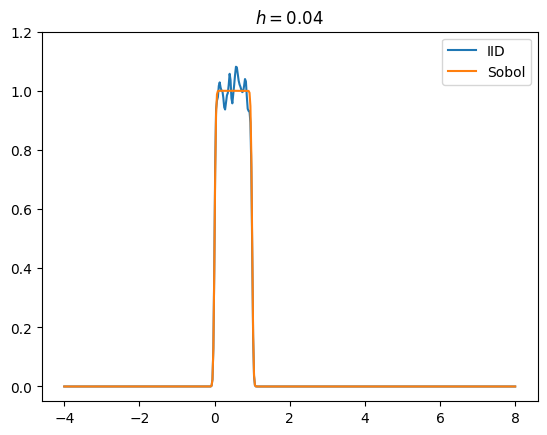

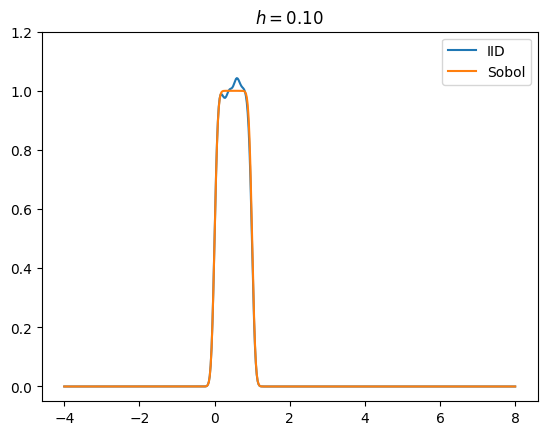

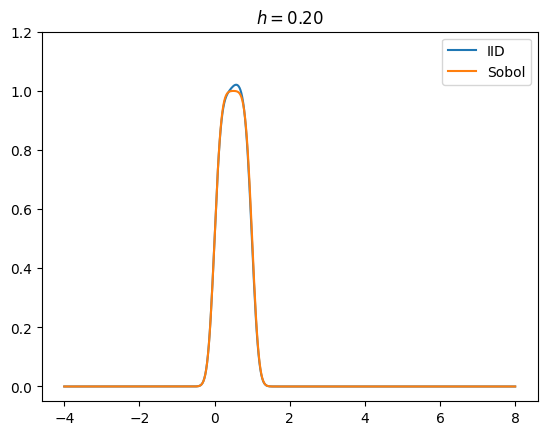

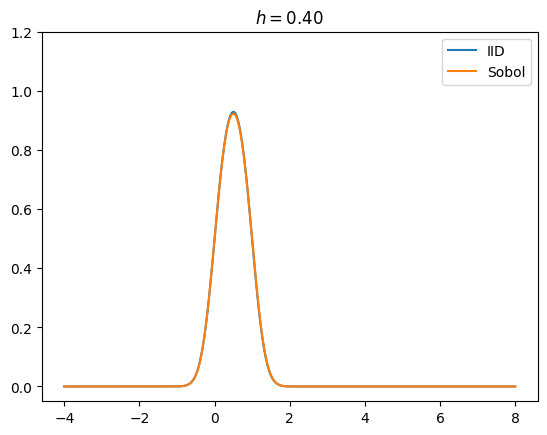

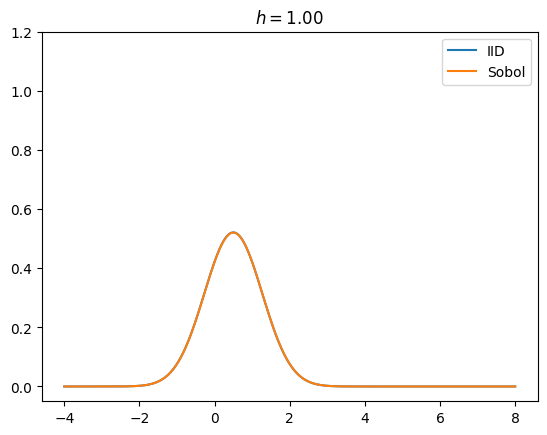

In [131]:
# graphing KDE for uniform: dim = 1, n = 2^12
bw = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
spaces = (-4, 8, 500)
generate_sobol_iid_graph(bw, spaces, kde, kernel, yiid_unif1, ysob_unif1)

### Sum of 2 uniform random variables (triangular)

In [84]:
def rmse_triangular(h, n, pts, kernel, kde):
    '''
    returns rmse for a KDE that estimates a uniformly distributed random variable
    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    '''

    sum_errors = 0

    triangular = np.linspace(-4, 8, 500)
    for i in range(len(triangular)):
        if 0 < triangular[i] < 1:
            triangular[i] = triangular[i]
        elif 1 <= triangular[i] < 2:
            triangular[i] = 2 - triangular[i]
        else:
            triangular[i] = 0
    
    rhoval = kde(kernel, pts, h, np.linspace(-4, 8, 500))

    for i in range(500):
        sum_errors += (triangular[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [85]:
def testfun_triangular(x, coord_wts = 1):  #takign one uniform rv and transofmring into a normal 
    wtx= np.multiply(x, coord_wts)

    # Parameters for the triangular distribution
    a = 0  # lower limit
    c = 1  # mode
    b = 2  # upper limit

    # Apply the inverse CDF method for the triangular distribution
    def inverse_triangular_cdf(pts, a, c, b):
        F_c = (c - a) / (b - a)
        return np.where(pts < F_c,
                        a + np.sqrt(pts * (b - a) * (c - a)),
                        b - np.sqrt((1 - pts) * (b - a) * (b - c)))

    triangular_rv = inverse_triangular_cdf(wtx, a, c, b)
    return triangular_rv

In [86]:
yiid1_triangular=testfun_triangular(iidpts1)
yiid3_triangular=testfun_triangular(iidpts3)

ysob1_triangular=testfun_triangular(sobpts1)
ysob3_triangular=testfun_triangular(sobpts3)

In [87]:
h_list = np.linspace(0.001, 1, 100)
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_triangular(h_list[i], 2**12, ysob1_triangular, kernel, kde))

In [88]:
min_index = rmse_list.index(min(rmse_list))
print("Minimum rmse = " 
      + str(rmse_list[min_index]) 
      + "\nand corresponding bandwidth is " 
      + str(h_list[min_index])
      + ".\nLog of bandwidth is "
      + str(np.log(h_list[min_index])))

Minimum rmse = 7.399270802107077e-05
and corresponding bandwidth is 0.011090909090909092.
Log of bandwidth is -4.501629507047251


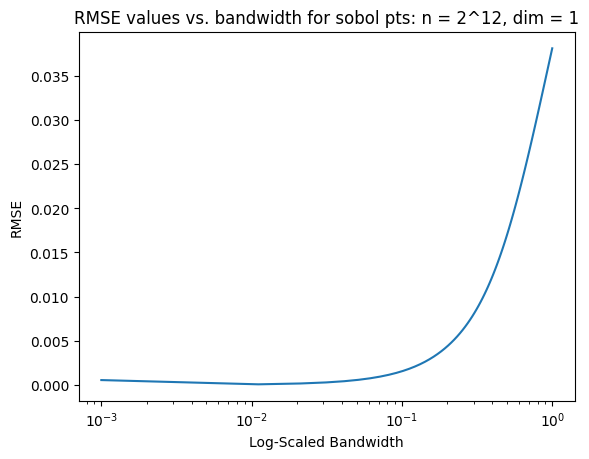

In [89]:
fix, ax = plt.subplots()
ax.plot(h_list, rmse_list)
ax.set_title("RMSE values vs. bandwidth for sobol pts: n = 2^12, dim = 1")
ax.set_xlabel('Log-Scaled Bandwidth')
ax.set_ylabel('RMSE')
ax.set_xscale('log')

In [90]:
# triangular (sum of 2 uniform random variables), iid, dim = 1
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_triangular(h_list[i], 2**14, yiid1_triangular, kernel, kde))
rmse_list

[0.008684266675940789,
 0.005884243704267074,
 0.0037578649552446205,
 0.002008938284103387,
 0.0012258120793393027,
 0.0009012636622717502,
 0.0010552181874502436,
 0.0022752728253186043,
 0.006192664221157573,
 0.01905786796554115]

In [91]:
# Import pandas library
import pandas as pd

# Initialize data to Dicts of series. uniform, iid, dim = 1
d = {'2^10': pd.Series([0.032735401326171774, 0.022526171924283432, 0.015143356852798632, 0.008906048140841297, 0.005694694497837144,
                        0.0040894047481934105, 0.0036597901923310873, 0.00846166057143792, 0.024163762362315877, 0.07607957745315179],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^11': pd.Series([0.023147424262599164, 0.015928408921834836, 0.010707970320541688, 0.006297527033962726, 0.0040267570962063655,
                       0.0028916458284640265, 0.002587862462717331, 0.00598329757016259, 0.017086360225373826, 0.0537963851269308],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^12': pd.Series([0.016367700663085887, 0.011263085962141716, 0.007571678426399316, 0.004453024070420648, 0.002847347248918572,
                       0.0020447023740967052, 0.0018298950961655436, 0.00423083028571896, 0.012081881181157939, 0.038039788726575895],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^13': pd.Series([0.011573712131299582, 0.007964204460917418, 0.005353985160270844, 0.003148763516981363, 0.0020133785481031828,
                       0.0014458229142320133, 0.0012939312313586654, 0.002991648785081295, 0.008543180112686913, 0.0268981925634654],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^14': pd.Series([0.008183850331542944, 0.005631542981070858, 0.003785839213199658, 0.002226512035210324, 0.001423673624459286,
                       0.0010223511870483526, 0.0009149475480827718, 0.00211541514285948, 0.006040940590578969, 0.019019894363287947],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1'])
                      }

# creates Dataframe.
df = pd.DataFrame(d)

# print the data.
print(df)

           2^10      2^11      2^12      2^13      2^14
0.001  0.032735  0.023147  0.016368  0.011574  0.008184
0.002  0.022526  0.015928  0.011263  0.007964  0.005632
0.004  0.015143  0.010708  0.007572  0.005354  0.003786
0.01   0.008906  0.006298  0.004453  0.003149  0.002227
0.02   0.005695  0.004027  0.002847  0.002013  0.001424
0.04   0.004089  0.002892  0.002045  0.001446  0.001022
0.1    0.003660  0.002588  0.001830  0.001294  0.000915
0.2    0.008462  0.005983  0.004231  0.002992  0.002115
0.4    0.024164  0.017086  0.012082  0.008543  0.006041
1      0.076080  0.053796  0.038040  0.026898  0.019020


Text(103.84722222222221, 0.5, 'Bandwidth')

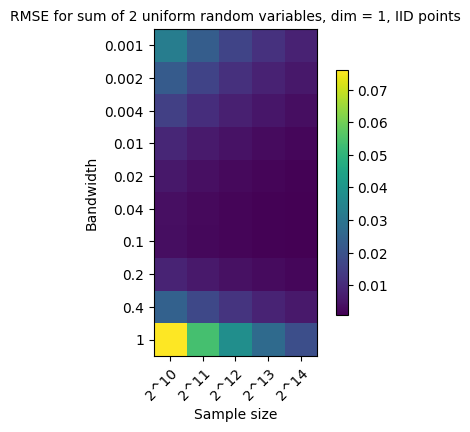

In [92]:
import numpy as np
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(df)
ax.set_title("RMSE for sum of 2 uniform random variables, dim = 1, IID points", size=10)
fig.tight_layout()

yaxis = df.index.values
xaxis = df.columns.values
# Add axis tick labels
ax.set_xticks(np.arange(len(xaxis)), 
              labels=xaxis)
ax.set_yticks(np.arange(len(yaxis)), 
              labels=yaxis)

cbar = ax.figure.colorbar(im, 
                          ax = ax,
                          shrink=0.75)

# Rotate the tick labels to be more legible
plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha = "right",
         rotation_mode = "anchor")

plt.xlabel("Sample size") 
plt.ylabel("Bandwidth") 

### Exponential Distribution

In [93]:
from scipy.stats import expon

In [94]:
def rmse_exp(h, n, pts, kernel, kde):
    '''
    returns rmse for a KDE that estimates a uniformly distributed random variable
    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    '''

    sum_errors = 0

    exp = np.linspace(-4, 8, 500)
    for i in range(len(exp)):
        exp[i] = expon.pdf(exp[i])
    
    rhoval = kde(kernel, pts, h, np.linspace(-4, 8, 500))

    for i in range(500):
        sum_errors += (exp[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [95]:
h_list = np.linspace(0.001, 1, 100)
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_unif(h_list[i], 2**12, ysob3_exp, kernel, kde))

In [96]:
h_list_log = []
for i in range(len(h_list)):
    h_list_log.append(np.log(h_list[i]))

In [97]:
min_index = rmse_list.index(min(rmse_list))
print("Minimum rmse = " 
      + str(rmse_list[min_index]) 
      + "\nand corresponding bandwidth is " 
      + str(h_list[min_index])
      + ".\nLog of bandwidth is "
      + str(np.log(h_list[min_index])))

Minimum rmse = 0.04871234930856709
and corresponding bandwidth is 0.011090909090909092.
Log of bandwidth is -4.501629507047251


Text(0, 0.5, 'RMSE')

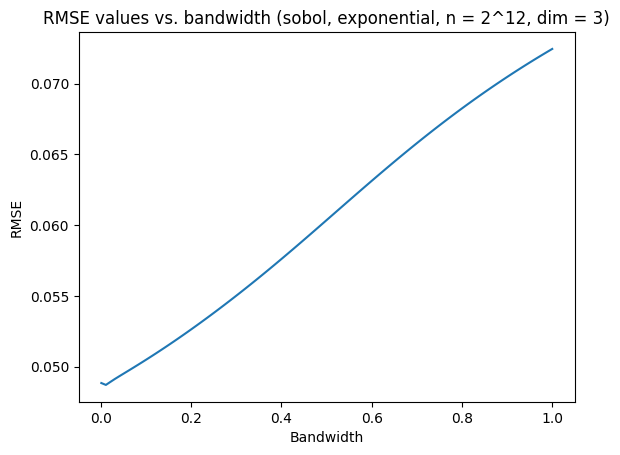

In [98]:
fix, ax = plt.subplots()
ax.plot(h_list, rmse_list)
ax.set_title("RMSE values vs. bandwidth (sobol, exponential, n = 2^12, dim = 3)")
ax.set_xlabel('Bandwidth')
ax.set_ylabel('RMSE')

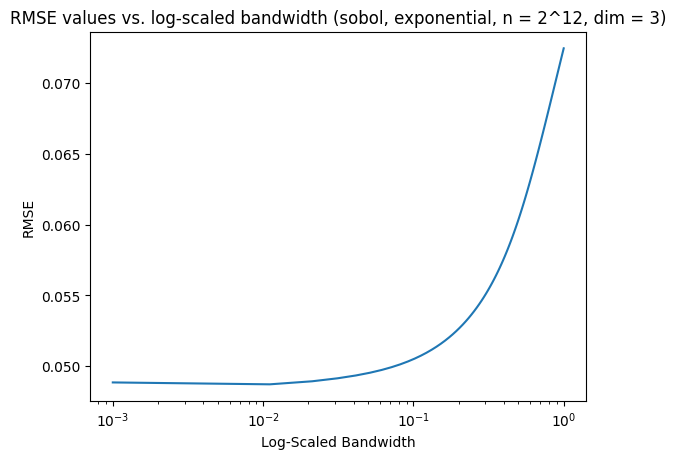

In [99]:
fix, ax = plt.subplots()
ax.plot(h_list, rmse_list)
ax.set_title("RMSE values vs. log-scaled bandwidth (sobol, exponential, n = 2^12, dim = 3)")
ax.set_xlabel('Log-Scaled Bandwidth')
ax.set_ylabel('RMSE')
ax.set_xscale('log')

Text(0, 0.5, 'RMSE')

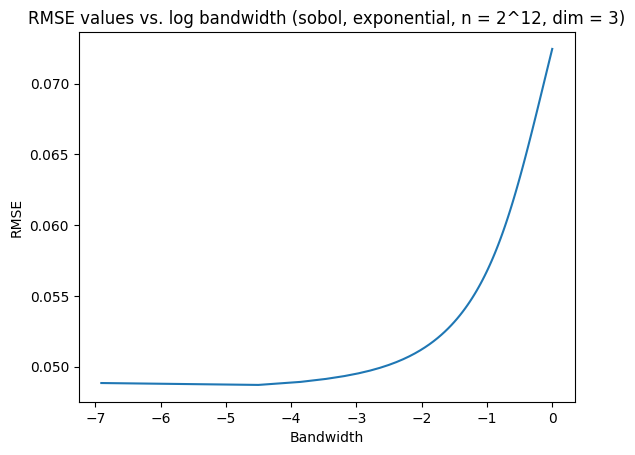

In [100]:
fix, ax = plt.subplots()
ax.plot(h_list_log, rmse_list)
ax.set_title("RMSE values vs. log bandwidth (sobol, exponential, n = 2^12, dim = 3)")
ax.set_xlabel('Bandwidth')
ax.set_ylabel('RMSE')

In [101]:
n_list = [2**10, 2**11, 2**12, 2**13, 2**14]
bandwidth = 0.011090909090909092
rmse_list = []

for n in n_list:
    # iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts(dimen = 1, n = n)
    iidpts3, sobpts3, latticepts3, dnetb2pts3, haltonpts3 = gen_iid_ld_pts(dimen = 1, n = n)
    # yiid_exp1 = testfun_exp(iidpts1)
    # ysob_exp1 = testfun_exp(sobpts1)
    # yiid_exp3 = testfun_exp(iidpts3)
    ysob_exp3 = testfun_exp(sobpts3)
    rmse_list.append(rmse_unif(bandwidth, n, ysob_exp3, kernel, kde))

Text(0, 0.5, 'RMSE')

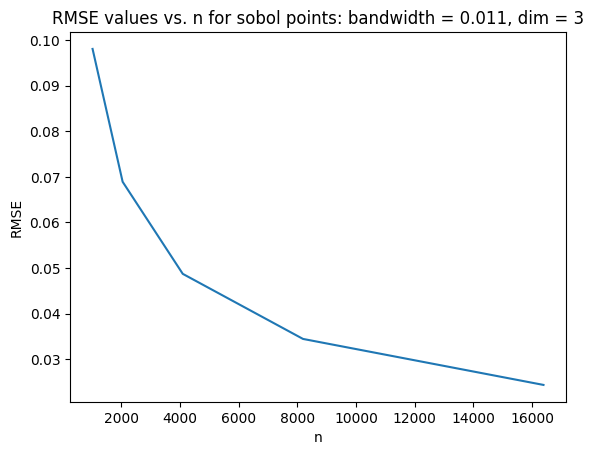

In [102]:
fix, ax = plt.subplots()
ax.plot(n_list, rmse_list)
ax.set_title("RMSE values vs. n for sobol points: bandwidth = 0.011, dim = 3")
ax.set_xlabel('n')
ax.set_ylabel('RMSE')

In [103]:
# exponential, iid, dim = 1, but with a different h_list
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_exp(h_list[i], 2**13, yiid1_exp, kernel, kde))
rmse_list

[0.021762949486514534,
 0.014594613148637603,
 0.00981151078335985,
 0.006398190566506049,
 0.005621499131457763,
 0.00658076863921674,
 0.00950193836132404,
 0.012978874946073556,
 0.017892707475342492,
 0.027017062873622728]

In [104]:
# Import pandas library
import pandas as pd

# Initialize data to Dicts of series. uniform, iid, dim = 1
d = {'2^10': pd.Series([0.05958390290990867, 0.04016553645267156, 0.03036624053402649, 0.020024869691335424, 0.017047688555856012,
                        0.01866025168269381, 0.027342419544862356, 0.037521657519024525, 0.05119957321027084, 0.0764344722742138],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^11': pd.Series([0.04213218179715728, 0.028401323195679527, 0.021472174600751938, 0.014159721151120243, 0.012054536181402087,
                       0.01319479050348048, 0.019334010274219767, 0.02653181847306145, 0.036203565410839605, 0.05404733366151172],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^12': pd.Series([0.029791951454954335, 0.02008276822633578, 0.015183120267013244, 0.010012434845667712, 0.008523844277928006,
                       0.009330125841346905, 0.013671209772431178, 0.018760828759512262, 0.02559978660513542, 0.0382172361371069],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^13': pd.Series([0.02106609089857864, 0.014200661597839764, 0.010736087300375969, 0.007079860575560122, 0.006027268090701044,
                       0.00659739525174024, 0.009667005137109884, 0.013265909236530725, 0.018101782705419803, 0.02702366683075586],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^14': pd.Series([0.014895975727477168, 0.01004138411316789, 0.007591560133506622, 0.005006217422833856, 0.004261922138964003,
                        0.004665062920673453, 0.006835604886215589, 0.009380414379756131, 0.01279989330256771, 0.01910861806855345],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1'])
                      }

# creates Dataframe.
df = pd.DataFrame(d)

# print the data.
print(df)

           2^10      2^11      2^12      2^13      2^14
0.001  0.059584  0.042132  0.029792  0.021066  0.014896
0.002  0.040166  0.028401  0.020083  0.014201  0.010041
0.004  0.030366  0.021472  0.015183  0.010736  0.007592
0.01   0.020025  0.014160  0.010012  0.007080  0.005006
0.02   0.017048  0.012055  0.008524  0.006027  0.004262
0.04   0.018660  0.013195  0.009330  0.006597  0.004665
0.1    0.027342  0.019334  0.013671  0.009667  0.006836
0.2    0.037522  0.026532  0.018761  0.013266  0.009380
0.4    0.051200  0.036204  0.025600  0.018102  0.012800
1      0.076434  0.054047  0.038217  0.027024  0.019109


Text(103.84722222222221, 0.5, 'Bandwidth')

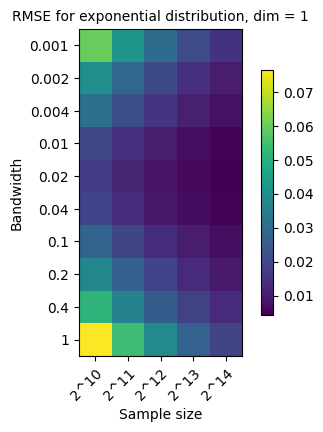

In [105]:
import numpy as np
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(df)
ax.set_title("RMSE for exponential distribution, dim = 1", size=10)
fig.tight_layout()

yaxis = df.index.values
xaxis = df.columns.values
# Add axis tick labels
ax.set_xticks(np.arange(len(xaxis)), 
              labels=xaxis)
ax.set_yticks(np.arange(len(yaxis)), 
              labels=yaxis)

cbar = ax.figure.colorbar(im, 
                          ax = ax,
                          shrink=0.75)

# Rotate the tick labels to be more legible
plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha = "right",
         rotation_mode = "anchor")

plt.xlabel("Sample size") 
plt.ylabel("Bandwidth") 

In [106]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 1)

# x = np.linspace(-4, 8, 500)
# ax.plot(x, expon.pdf(x),
#        'r-', lw=5, alpha=0.6, label='expon pdf')

In [107]:
# def true_function(x):
#     return expon.pdf(x)

In [108]:
# # bandwidth = 0.1
# def estimated_pts(x):
#     return kde_pt(kernel, yiid1_exp, 0.1, x)

In [109]:
# def squared_difference_pts(x):
#     return (true_function(x) - estimated_pts(x))**2

In [110]:
# result = integrate.quad(squared_difference_pts, -4, 8)
# print(result)

### Laplace Distribution

The inverse CDF of the Laplace distribution with location parameter 𝜇 and scale parameter 𝑏 is given by:
$$
F^{-1}(x) = \text{𝜇} - \text{𝑏} \cdot \text{sign}(x-0.5) \cdot \text{ln}(1-2|x-0.5|)
$$

where $x$ is a uniform random variable in the interval $[0,1]$.

In [111]:
def rmse_laplace(h, n, pts, kernel, kde):
    '''
    returns rmse for a KDE that estimates a uniformly distributed random variable
    h = bandwidth
    n = number of points
    pts = set of iid or ld points
    kernel = kernel function
    kde = kde function
    '''

    sum_errors = 0

    laplace = np.linspace(-4, 8, 500)
    
    # Define location (mean) and scale parameters
    loc = 0
    scale = 1.0
 
    # Create a Laplace distribution object
    laplace_dist = stats.laplace(loc, scale)

    for i in range(len(laplace)):
        laplace[i] = laplace_dist.pdf(laplace[i])
    
    rhoval = kde(kernel, pts, h, np.linspace(-4, 8, 500))

    for i in range(500):
        sum_errors += (laplace[i] - rhoval[i])**2
    
    rmse = np.sqrt((1/n)*sum_errors)
    return rmse

In [112]:
def testfun_laplace(x, coord_wts = 1):  #takign one uniform rv and transforming into a laplace 
    wtx= np.multiply(x, coord_wts)

    def uniform_to_laplace(u, mu=0, b=1):
        return mu - b * np.sign(u - 0.5) * np.log(1 - 2 * np.abs(u - 0.5))

    laplace_rv = uniform_to_laplace(wtx, mu=0, b=1)
    return laplace_rv

In [113]:
yiid1_laplace=testfun_laplace(iidpts1)
yiid3_laplace=testfun_laplace(iidpts3)

ysob1_laplace=testfun_laplace(sobpts1)
ysob3_laplace=testfun_laplace(sobpts3)

In [114]:
h_list = np.linspace(0.001, 1, 100)
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_laplace(h_list[i], 2**12, ysob3_laplace, kernel, kde))

In [115]:
min_index = rmse_list.index(min(rmse_list))
print("Minimum rmse = " 
      + str(rmse_list[min_index]) 
      + "\nand corresponding bandwidth is " 
      + str(h_list[min_index])
      + ".\nLog of bandwidth is "
      + str(np.log(h_list[min_index])))

Minimum rmse = 0.00012113060319258318
and corresponding bandwidth is 0.03127272727272727.
Log of bandwidth is -3.4650088944071094


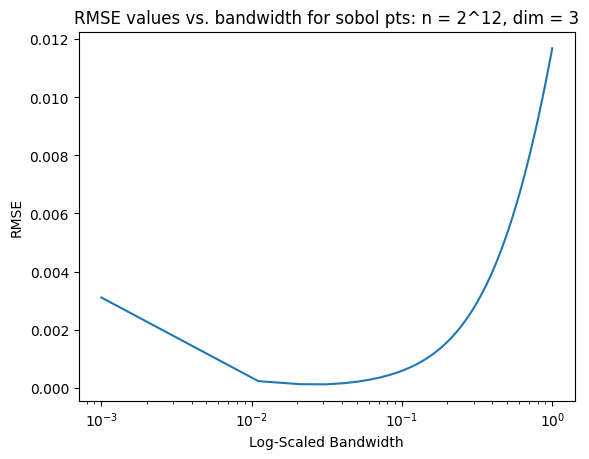

In [116]:
fix, ax = plt.subplots()
ax.plot(h_list, rmse_list)
ax.set_title("RMSE values vs. bandwidth for sobol pts: n = 2^12, dim = 3")
ax.set_xlabel('Log-Scaled Bandwidth')
ax.set_ylabel('RMSE')
ax.set_xscale('log')

In [117]:
# laplace, iid, dim = 1
h_list = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 1]
rmse_list = []
for i in range(len(h_list)):
    rmse_list.append(rmse_laplace(h_list[i], 2**14, yiid1_laplace, kernel, kde))
rmse_list

[0.007418917334897055,
 0.005210881832186353,
 0.003702580163362288,
 0.0023227150699919557,
 0.0015034648350462942,
 0.0009372542219208407,
 0.0006565182115332599,
 0.0009777968587997175,
 0.002063156852581817,
 0.005848069564398794]

In [118]:
# Import pandas library
import pandas as pd

# Initialize data to Dicts of series. uniform, iid, dim = 1
d = {'2^10': pd.Series([0.0650636498689863, 0.045457131653597674, 0.03147447260517071, 0.020136100801925707, 0.013805624108738602,
                        0.009656634372704032, 0.006783762789813927, 0.006870742611128379, 0.010219324011873676, 0.02486123511758178],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^11': pd.Series([0.046006948031107435, 0.03214304604554857,.02225581301338643, 0.014238373423697546, 0.009762050425801552,
                       0.006828271648378123, 0.0047968446706384, 0.004858348692116243, 0.007226153307938391, 0.01757954794031521],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^12': pd.Series([0.03253182493449315, 0.022728565826798837, 0.015737236302585354, 0.010068050400962853, 0.006902812054369301,
                       0.004828317186352016, 0.0033918813949069637, 0.0034353713055641894, 0.005109662005936838, 0.01243061755879089],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^13': pd.Series([0.023003474015553717, 0.016071523022774287, 0.011127906506693215, 0.007119186711848773, 0.004881025212900776,
                       0.0034141358241890616, 0.0023984223353192, 0.0024291743460581215, 0.0036130766539691954, 0.008789773970157604],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1']),
    '2^14': pd.Series([0.016265912467246575, 0.011364282913399418, 0.007868618151292677, 0.005034025200481427, 0.0034514060271846505,
                       0.002414158593176008, 0.0016959406974534819, 0.0017176856527820947, 0.002554831002968419, 0.006215308779395445],
                      index=['0.001', '0.002', '0.004', '0.01', '0.02', '0.04', '0.1', '0.2', '0.4', '1'])
                      }

# creates Dataframe.
df = pd.DataFrame(d)

# print the data.
print(df)

           2^10      2^11      2^12      2^13      2^14
0.001  0.065064  0.046007  0.032532  0.023003  0.016266
0.002  0.045457  0.032143  0.022729  0.016072  0.011364
0.004  0.031474  0.022256  0.015737  0.011128  0.007869
0.01   0.020136  0.014238  0.010068  0.007119  0.005034
0.02   0.013806  0.009762  0.006903  0.004881  0.003451
0.04   0.009657  0.006828  0.004828  0.003414  0.002414
0.1    0.006784  0.004797  0.003392  0.002398  0.001696
0.2    0.006871  0.004858  0.003435  0.002429  0.001718
0.4    0.010219  0.007226  0.005110  0.003613  0.002555
1      0.024861  0.017580  0.012431  0.008790  0.006215


Text(103.84722222222221, 0.5, 'Bandwidth')

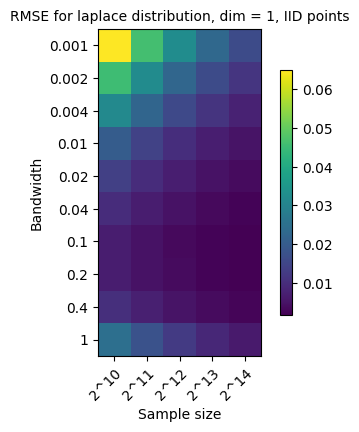

In [119]:
import numpy as np
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(df)
ax.set_title("RMSE for laplace distribution, dim = 1, IID points", size=10)
fig.tight_layout()

yaxis = df.index.values
xaxis = df.columns.values
# Add axis tick labels
ax.set_xticks(np.arange(len(xaxis)), 
              labels=xaxis)
ax.set_yticks(np.arange(len(yaxis)), 
              labels=yaxis)

cbar = ax.figure.colorbar(im, 
                          ax = ax,
                          shrink=0.75)

# Rotate the tick labels to be more legible
plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha = "right",
         rotation_mode = "anchor")

plt.xlabel("Sample size") 
plt.ylabel("Bandwidth") 

In [120]:
# https://www.askpython.com/python/examples/laplace-distribution-python
# from scipy import stats
 
# # Define location (mean) and scale parameters
# loc = 0
# scale = 1.0
 
# # Create a Laplace distribution object
# laplace_dist = stats.laplace(loc, scale)
 
# # Calculate the PDF for a specific value (x = 3.0)
# x = 3.0
# pdf_value = laplace_dist.pdf(x)
 
# print(f"PDF for x = {x}: {pdf_value}")
 
# # Alternatively, calculate the PDF for an array of values
# x_values = np.linspace(1.0, 4.0, 10)
# pdf_values = laplace_dist.pdf(x_values)
# print(pdf_values)
 
# # Plot the PDF (using matplotlib)
# import matplotlib.pyplot as plt
 
# plt.plot(x_values, pdf_values)
# plt.xlabel("x")
# plt.ylabel("PDF(x)")
# plt.title("Laplace Distribution PDF")
# plt.show()

In [121]:
# making a second set of iid and sobol points

# iidpts1_2, sobpts1_2 = gen_iid_and_sobol(dimen = 1, n = 2**12)
# iidpts3_2, sobpts3_2 = gen_iid_and_sobol(dimen = 3, n = 2**12)

In [122]:
# yiid_laplace = testfun_laplace(iidpts1, iidpts1_2) 
# ysob_laplace = testfun_laplace(sobpts1, sobpts1_2)

# yiid_laplace_3 = testfun_laplace(iidpts3, iidpts3_2) 
# ysob_laplace_3 = testfun_laplace(sobpts3, sobpts3_2)

In [123]:
# def true_function(x):
#     return laplace_dist.pdf(x)

In [124]:
# bandwidth = 0.1
# def estimated_pts(x):
#     return kde_pt(kernel, yiid_laplace, 0.1, x)

In [125]:
# def squared_difference_pts(x):
#     return (true_function(x) - estimated_pts(x))**2

In [126]:
# result = integrate.quad(squared_difference_pts, -4, 8)
# print(result)

In [127]:
# h_optimal = 0
# min_mise = 100000

# for h in np.linspace(0.001, 2, 100):
#     def estimated_pts(x):
#         return kde_pt(kernel, yiid_laplace, h, x)
#     def squared_difference_pts(x):
#         return (true_function(x) - estimated_pts(x))**2
#     mise, error = integrate.quad(squared_difference_pts, -4, 8)
#     if mise < min_mise:
#         min_mise = mise
#         h_optimal = h

# print(h_optimal, min_mise)

## Profiling code

In [128]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
import pprofile
import sys

In [129]:
## defining functions
# QMC Point Generators
def gen_iid_ld_pts(dimen = 3, n = 2**12):
    """
    Generate IID, Sobol, Lattic, DNB2, and Halton sample points,
    based on dimension and smaple size.
    """
    coord_wts = 2.0**(-np.array(range(0, dimen)))
    iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
    sobpts = qp.Sobol(dimen).gen_samples(n)
    latticepts = qp.Lattice(dimen).gen_samples(n)
    dnetb2pts = qp.DigitalNetB2(dimen).gen_samples(n)
    haltonpts = qp.Halton(dimen).gen_samples(n)
    return (iidpts, sobpts, latticepts, dnetb2pts, haltonpts)

# Kernels
# hardcoding hermite kernel coefficients
def hardcode_hermite_kernel(r):
    '''
    returns hermite coefficients for r = 0, 1, or 2
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    if r == 0:
        return sy.Matrix([[1/(math.pi)**0.5]])
    elif r == 1:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5)]])
    elif r == 2:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5), 1/(32*(math.pi)**0.5)]])
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")

# hardcoded: define hermite kernel for r = 0 (corresponds to r = 1 in the original case)
def hardcode_hermite_kernel_weight(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y) * coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0, r):
        k += sp.special.hermite(2*ii)(y) * coef[0][ii] #add the additional terms
    k *= np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

# hardcoding hermite kernel coefficients without sympy
def hardcode_hermite_kernel_simple(r):
    '''
    returns hermite coefficients for r = 0, 1, or 2
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    if r==0:
        return np.matrix([[1/(math.pi)**0.5]])
    elif r==1:
        return np.matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5)]])
    elif r==2:
        return np.matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5), 1/(32*(math.pi)**0.5)]])
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")
    
# using simplified np.matrix for coefficients, instead of sympy.matrix
def hardcode_hermite_kernel_weight_v2(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel_simple(r = r)))
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y) * coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0, r):
        k += sp.special.hermite(2*ii)(y) * coef[0][ii] #add the additional terms
    k *= np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k
    
# hardcoded without scipy: define hermite kernel for r = 0 (corresponds to r = 1 in the original case)
# for some reason, not returning same values as original kernel
def simple_hardcode_hermite_kernel_weight(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    hermite_polys = [sp.poly1d([1.]), sp.poly1d([4.,  0., -2.]), sp.poly1d([ 1.6000000e+01,  0.0000000e+00, -4.8000000e+01, -8.8817842e-16,
        1.2000000e+01])]
    # print(coef)
    # poly = sp.special.hermite(0)
    # print(poly)
    k = sp.poly1d([1.])(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += hermite_polys[r](y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

# PDFs
# Unamed distribution
def testfun(x):
    return 10 * np.exp(-x) * np.sin(np.pi*x)

# Guassian distribution
def guass_distr(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    y = 10 * np.exp(-wtx.sum(1)) * np.sin(np.pi * wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

# KDEs
def kde_pt(kernel, ypts, bandwidth, yeval):
    return np.mean(kernel((yeval-ypts) / bandwidth)) / bandwidth

# def estimated_pts(x):
#     return kde_pt(hardcode_hermite_kernel_weight, pts, h, x)

# def squared_difference_pts(x):
#     return (hardcode_hermite_kernel_weight - estimated_pts(x))**2

# Integration operation from SciPy
def integration_test(h, pts, kde, kernel, true_function):
        def estimated_pts(x):
            return kde(kernel, pts, h, x)
        def squared_difference_pts(x):
            return (true_function(x) - estimated_pts(x))**2
        mise, error = sp.integrate.quad(squared_difference_pts, -4, 8) # This seems to be taking the longest. Will investigate.
        return (mise, error)

# All operations
def optimal_h(h_space, pts, kde, kernel, true_function):
    '''
    returns optimal bandwidth and lowest value of MISE
    h_space: a set of bandwidths to be tested (e.g., np.linspace(0.001, 3, 100))
    pts: set of randomly generated points (IID or LD)
    kde: kde function
    kernel: function that defines kernel
    true_function: function that we are trying to estimate (e.g., f(x), laplace, uniform, exponential, etc.)
    '''
    h_optimal = 0
    lowest_mise = np.inf
    for h in h_space:
        def estimated_pts(x):
            return kde(kernel, pts, h, x)
        def squared_difference_pts(x):
            return (true_function(x) - estimated_pts(x))**2
        mise, error = sp.integrate.quad(squared_difference_pts, -4, 8) # TODO: Fix this interval of integration so that it makes sense. Should probably be parameterized as well.
        if mise < lowest_mise:
            lowest_mise = mise
            h_optimal = h

    return(lowest_mise, h_optimal)

In [ ]:
# Functions to test
# Alternatives to SciPy's integration

iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**12)
yiid1 = guass_distr(iidpts1)
test_option = '6'

profiler = pprofile.Profile()
with profiler:
    if test_option in ('optimal_h' ,'0'):
        result = optimal_h(np.linspace(0.001, 2, 2), yiid1, kde_pt, hardcode_hermite_kernel_weight, testfun)
    elif test_option in ('kde_pt', '1'):
        result = kde_pt(hardcode_hermite_kernel_weight, yiid1, 0.5, 2.0)
    # elif test_option == 'hardcode_hermite_kernel_weight':
    #     # result = hardcode_hermite_kernel_weight(y, r)
    elif test_option in ('hardcode_hermite_kernel', '2'):
        r_number = int(2)
        print(hardcode_hermite_kernel(r_number))
    elif test_option in ('hardcode_hermite_kernel', '3'):
        r_number = int(2)
        result = hardcode_hermite_kernel_weight(y=yiid1, r=r_number)
    elif test_option in ('integration_test', '4'):
        mise, error = integration_test(0.1, yiid1, kde_pt, hardcode_hermite_kernel_weight, testfun)
    elif test_option in ('hardcode_hermite_kernel_simple', '5'):
        print(hardcode_hermite_kernel_simple(2)) # testing when r = 2
    elif test_option in ('simple_hardcode_hermite_kernel_weight', '6'):
        print(simple_hardcode_hermite_kernel_weight(y=yiid1, r=2))
    elif test_option in ('hardcode_hermite_kernel_weight_v2', '7'):
        result = hardcode_hermite_kernel_weight_v2(y=yiid1, r=2)
    else:
        raise Exception

profiler.print_stats()

In [ ]:
#testing